video_id             object
timestamp    datetime64[ns]
count                 int64
dtype: object


C:\Users\lehnen\AppData\Local\Temp\ipykernel_14652\444222072.py:69: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(ymin, ymax)


(919.6, 1016.4)

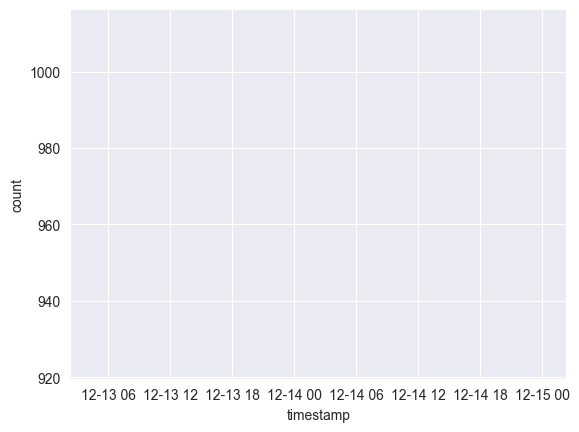

In [53]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

# Create empty dict
file_dict = {}

# Get list of files in directory
files = os.listdir('data/images/cropped')

# Loop through the files
for file in files:
    # Split the filenames
    parts = file.split('_')
    if parts[0] == 'image':
        video_id = parts[1]
        timestamp = parts[2] + "_" + parts[3]
        # Convert the timestamp string to a datetime object
        timestamp = pd.to_datetime(timestamp, format='%Y-%m-%d_%H-%M-%S')
        # Create a key for the dictionary using the video_id and timestamp
        key = f"{video_id}_{timestamp}"
        # If the key doesn't exist in the dictionary, create a new list for it
        if key not in file_dict:
            file_dict[key] = []
        # Append the file path to the list of file paths for this key
        file_dict[key].append(os.path.join('data/images/cropped', file))

# Print results
# print(files)
# print(file_dict)

# Create pandas dataframe from the dictionary
df = pd.DataFrame(columns=['video_id', 'timestamp', 'count'])
for key, value in file_dict.items():
    # Get the count of file paths for the current key
    count = len(value)
    
    # Create a new DataFrame for the current key
    new_df = pd.DataFrame({'video_id': [video_id], 'timestamp': [timestamp], 'count': [count]})
    
    # Append the new DataFrame to the existing DataFrame
    df = pd.concat([df, new_df], ignore_index=True)

df['count'] = pd.to_numeric(df['count'], errors='coerce')
    
print(df.dtypes)
df

df = df.groupby(['video_id', 'timestamp'])['count'].sum().reset_index()

# Sort the dataframe by the timestamp column
df = df.sort_values('timestamp')

# Use seaborn to create a lineplot
sns.lineplot(x='timestamp', y='count', data=df)

# Get the minimum and maximum values of the 'timestamp' column
xmin, xmax = df['timestamp'].min(), df['timestamp'].max()

# Set the x-axis limits to cover a few days
plt.xlim(xmin, xmin + timedelta(days=2))

# Get the minimum and maximum values of the 'count' column
ymin, ymax = df['count'].min(), df['count'].max()

# Set the y-axis limits to cover the range of values in the 'count' column
plt.ylim(ymin, ymax)

In [54]:
df

,video_id,timestamp,count
0,ydYDqZQpim8,2022-12-13 02:18:41,968


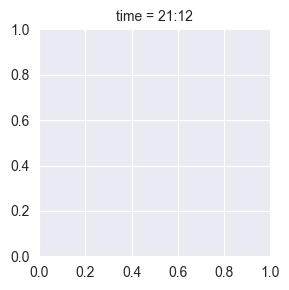

In [45]:
# Create a new column with the minute and second values
df['time'] = df['timestamp'].apply(lambda x: x.strftime('%M:%S'))

# Create a FacetGrid with a subplot for each minute and second value
g = sns.FacetGrid(df, col='time')
